La comunidad de Madrid no tiene base de datos con las coordenadas o direccion de estas. El ayuntamiento de Madrid si los tiene para aquellos dentro de la ciudad propia pero no es suficiento. Usaremos OSM para complementar esta.

In [77]:
import pandas as pd
import geopandas as gpd
import osmnx
from shapely import Point, distance
import contextily as cx
from tqdm import tqdm

### bibliotecas dentro de la ciudad

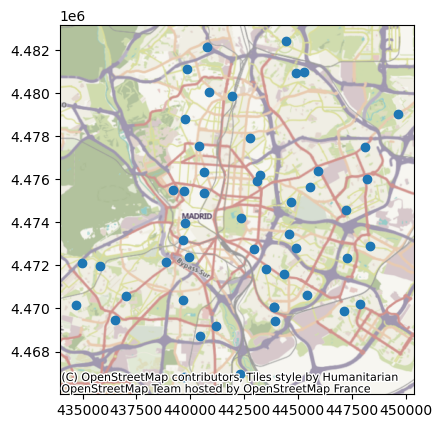

In [50]:
gdf_biblioCiudadMadrid = pd.read_csv('bibliotecasAyuntamientoMadrid.csv', delimiter=';', encoding='latin')[['PK', 'NOMBRE',  'BARRIO', 'COD-DISTRITO', 'DISTRITO',
                                                                                                             'COORDENADA-X', 'COORDENADA-Y']]
gdf_biblioCiudadMadrid['geometry'] = gdf_biblioCiudadMadrid[['COORDENADA-X', 'COORDENADA-Y']].apply(lambda x : Point(x['COORDENADA-X'], x['COORDENADA-Y']), axis=1)
gdf_biblioCiudadMadrid = gdf_biblioCiudadMadrid.set_geometry('geometry')
gdf_biblioCiudadMadrid = gdf_biblioCiudadMadrid.set_crs('EPSG:32630')
ax = gdf_biblioCiudadMadrid.plot()
cx.add_basemap(crs=gdf_biblioCiudadMadrid.crs, ax=ax)

### bibliotecas en la comunidad

In [88]:
gdf_bibliotecasComunidad = osmnx.features_from_place(
    query='Community of Madrid',
    tags = {'amenity' : 'library'}
).loc[:, ['geometry', 'amenity', 'name']]

gdf_bibliotecasComunidad = gdf_bibliotecasComunidad.to_crs('EPSG:3035')

gdf_bibliotecasComunidad['geometry'] = gdf_bibliotecasComunidad['geometry'].centroid

gdf_bibliotecasComunidad = gdf_bibliotecasComunidad.to_crs('EPSG:32630')

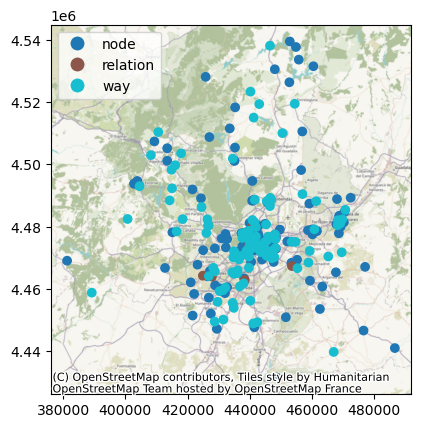

In [69]:
ax = gdf_bibliotecasComunidad.reset_index().plot(column='element', legend=True)
cx.add_basemap(crs = gdf_bibliotecasComunidad.crs, ax = ax)

### Consolidación

In [ ]:
gdf_biblioCiudadMadrid.sjoin_nearest(gdf_bibliotecasComunidad, max_distance=100).shape

(44, 12)

Solo 44 de las bibliotecas presentes en la ciudad de Madrid tienen una correspondencia a una biblioteca dentro del dataset de OSM. Por esto, tomaremos la base de datos de el ayuntamiento de Madrid como base y le agregaremos a esta los POIs de OSM.

In [85]:
gdf_biblioCiudadMadrid.head(1)

,PK,NOMBRE,BARRIO,COD-DISTRITO,DISTRITO,COORDENADA-X,COORDENADA-Y,geometry
0,25526,Biblioteca Pública Antonio Mingote (Latina),LAS AGUILAS,10.0,LATINA,434685,4470157,POINT (3153209.535 2026781.091)


In [86]:
gdf_bibliotecasComunidad.head(1)

,,geometry,amenity,name
element,id,,,
node,167386167,POINT (3160680.134 2030394.393),library,Biblioteca Nacional de España


Primero preparamos los dataframes para que tengan las mismas columnas

In [89]:
gdf_bibliotecasComunidad = gdf_bibliotecasComunidad.reset_index()
gdf_bibliotecasComunidad = gdf_bibliotecasComunidad.drop(['element', 'amenity'], axis=1)
gdf_bibliotecasComunidad = gdf_bibliotecasComunidad.rename({'name' : 'NOMBRE', 'id' : 'PK'}, axis=1)
gdf_bibliotecasComunidad.head(1)

,PK,geometry,NOMBRE
0,167386167,POINT (441475.366 4475017.046),Biblioteca Nacional de España


  0%|          | 0/247 [00:00<?, ?it/s]

100%|██████████| 247/247 [00:02<00:00, 113.06it/s]


total rows added : 189


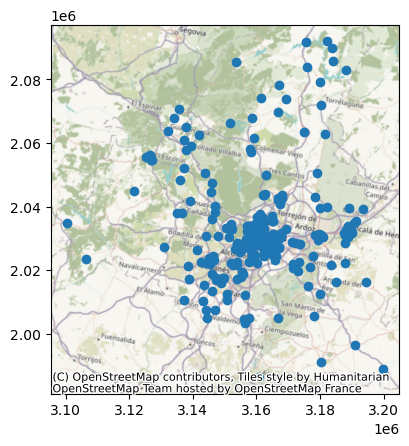

In [118]:
gdf_biblioCiudadMadrid = gdf_biblioCiudadMadrid.to_crs('EPSG:3035')
gdf_bibliotecasComunidad = gdf_bibliotecasComunidad.to_crs('EPSG:3035')

gdf_bibliotecasTodo = gdf_biblioCiudadMadrid.copy()

i = 0
for row in tqdm(gdf_bibliotecasComunidad.iterrows(), total=gdf_bibliotecasComunidad.shape[0]):
    valid = True
    row = row[1]
    for libInSet in gdf_bibliotecasTodo['geometry']:
        if distance(row.geometry, libInSet) <= 200:
            valid = False
            break
    
    if valid:
        gdf_bibliotecasTodo = pd.concat([ gdf_bibliotecasTodo, gpd.GeoDataFrame(row).transpose().set_geometry('geometry').set_crs('EPSG:3035') ])
        i = i + 1

print(f'total rows added : {i}')

ax = gdf_bibliotecasTodo.plot()
cx.add_basemap(crs= gdf_bibliotecasTodo.crs, ax = ax)

In [119]:
gdf_bibliotecasTodo.to_file('./cleaned/bibliotecasTodo.geojson')